In [1]:
import xarray as xr

area = xr.open_dataarray('old_Regional_masks_and_area/area_files/AREA.nc')
# netcdf of grid cell areas

CJK_mask = xr.open_dataarray('old_Regional_masks_and_area/masks/CJK/CJK_binary_assign_coords.nc')
NPO_mask = xr.open_dataarray('area_weighted_NPO_lower_bound_20_deg.nc')
# Binary mask for East Asia and an area-weighted mask for North Pacific Ocean with lower bound of 20°N

SFSO2 = xr.open_dataset('b.e21.BHIST.f09_g17.CMIP6-historical.003.cam.h0.SFSO2.185001-201412.nc')['SFSO2'].where(CJK_mask) * area
# SO2 surface flux, kg/m2/s
# masked to East Asia and multiplied by grid cell area

SO2_CMXF = xr.open_dataset('b.e21.BHIST.f09_g17.CMIP6-historical.003.cam.h0.SO2_CMXF.185001-201412.nc')['SO2_CMXF'].where(CJK_mask) * area
# Vertically integrated external forcing for SO2, kg/m2/s
# masked to East Asia and multiplied by grid cell area

total_SO2_from_surface_and_column_ = SFSO2 + SO2_CMXF


AODSO4dn = xr.open_dataset('b.e21.BHIST.f09_g17.CMIP6-historical.003.cam.h0.AODSO4dn.185001-201412.nc')['AODSO4dn'].where(NPO_mask)
# Aerosol optical depth 550 nm from SO4, day night
# Masked by area weighted NPO mask


In [2]:
def return_list_of_months(ds, months, operation):
    to_fill = []
    for month in months: 
        if operation =='sum':
            filling = ds.sel(time=ds.time[ds.time.dt.month == month]).sum(dim=['lat', 'lon'])
            to_fill.append(filling)
        elif operation =='mean':
            filling = ds.sel(time=ds.time[ds.time.dt.month == month]).mean(dim=['lat', 'lon'])
            to_fill.append(filling)
    return to_fill

months_total_SO2_from_surface_and_column_ = return_list_of_months(total_SO2_from_surface_and_column_, [3,6,9,12], 'sum') 
# returns the total sum of SO2 flux from East Asia

months_AODSO4dn = return_list_of_months(AODSO4dn, [3,6,9,12], 'mean')
# returns the spatial average of NPO AODSO4


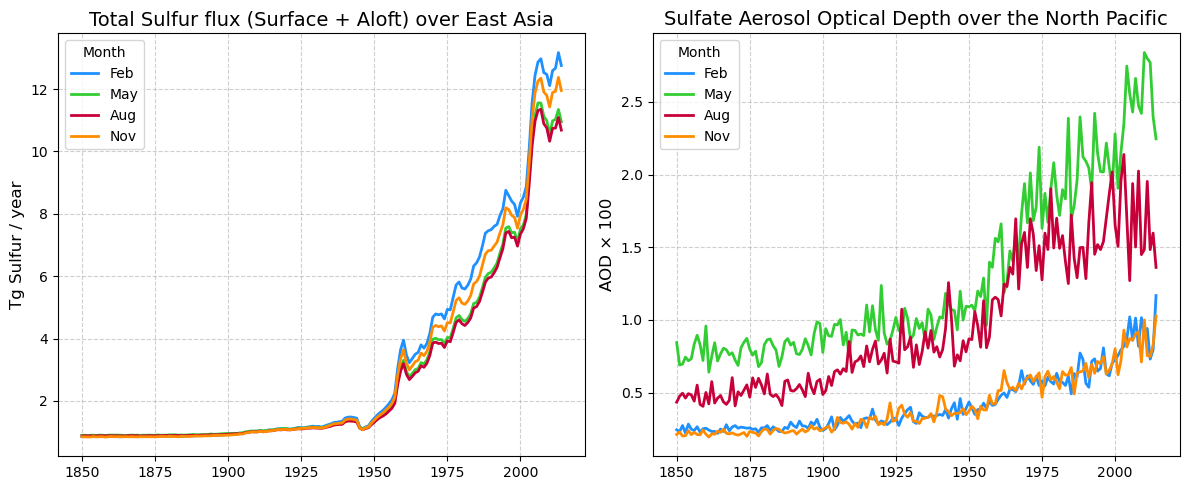

In [3]:
import matplotlib.pyplot as plt

# Match each label to a color based on seasonal perception
labels = ['Feb', 'May', 'Aug', 'Nov']
label_to_color = {
    'Feb': "#1E90FF",  # Cool winter blue
    'May': "#32CD32",  # Fresh spring green
    'Aug': "#C70039",  # Hot summer red
    'Nov': "#FF8C00"   # Warm autumn orange
}

seconds_per_year = 60 * 60 * 24 * 365
Kg_to_Tg = 1e-9
S_SO4_ratio = 32.065/115.107

multiplier = seconds_per_year * Kg_to_Tg * S_SO4_ratio

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Plot sulfur fluxes (Tg SO4/year)
for i, label in zip(months_total_SO2_from_surface_and_column_, labels):
    axs[0].plot(i.time.dt.year, i*multiplier, label=label, color=label_to_color[label], linewidth=2)
axs[0].set_ylabel('Tg Sulfur / year', fontsize=12)
axs[0].set_title('Total Sulfur flux (Surface + Aloft) over East Asia', fontsize=14)
axs[0].grid(linestyle='--', alpha=0.6)
axs[0].legend(title='Month', fontsize=10, loc="upper left")

# Plot sulfate AOD
for j, label in zip(months_AODSO4dn, labels):
    axs[1].plot(j.time.dt.year, j * 100, label=label, color=label_to_color[label], linewidth=2)
    
axs[1].set_ylabel("AOD × 100", fontsize=12)
axs[1].set_title("Sulfate Aerosol Optical Depth over the North Pacific", fontsize=14)
axs[1].grid(linestyle='--', alpha=0.6)
axs[1].legend(title='Month', fontsize=10, loc="upper left")


# years = [1850, 1970, 2000, 2006]
# labels = ["Preindustrial \nBaseline", "Early \nCJK", "Control", "Peak \nCJK"]
# line_color = 'black'
# line_style = '--'
# line_alpha = 0.7
# offsets = [0, 0, -4, 4]  # Customize horizontal nudge for each label
# for ax in axs:
#     for year, label, offset in zip(years, labels, offsets):
#         # Draw vertical line
#         ax.axvline(x=year, color=line_color, linestyle=line_style, alpha=line_alpha, zorder=2)

#         # Label below x-axis with horizontal shift
#         ax.text(year + offset, -0.12, label, transform=ax.get_xaxis_transform(), ha='center', va='top',
#                 fontsize=9, color=line_color, rotation=0)

plt.tight_layout()
plt.show()